# Tarea KMeans & Shap

Diego Lozoya Morales | 745345

# Paqueterías

In [1]:
import numpy as np
import pandas as pd
import shap 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
plt.rcParams['figure.facecolor'] = 'lightgrey'
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

colors = ["cornflowerblue", "indianred", "darkseagreen", "plum", "dimgray"]

# Funciones

In [2]:
def calibracion(predicciones, y_test):
    df_calibracion = pd.DataFrame({
        'predicciones':predicciones,
        'y':y_test
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=15, labels=False)+1
    grouped = df_calibracion.groupby('bins').mean()

    plt.figure()
    plt.plot(grouped.predicciones, grouped.y, label="Modelo", marker="o", color=colors[0])
    plt.plot(grouped.predicciones, grouped.predicciones, label="Real", marker="o", color=colors[1])
    plt.xlabel("Prediccion")
    plt.ylabel("Real")
    plt.title("Calibración")
    plt.legend()
    plt.show()

def histograma(probabilidades, y_test):
     df = pd.DataFrame({
     'real': y_test,
     'probabilidades': probabilidades
     })

     plt.figure()
     plt.hist(df[df.real == 1]['probabilidades'], density=True, color=colors[0], alpha=0.5, label = '1')
     plt.hist(df[df.real == 0]['probabilidades'], density=True, color=colors[1], alpha=0.5, label = '0')
     plt.title(f'Histograma de probabilidades')
     plt.xlabel("Probabilidad")
     plt.ylabel(" ")
     plt.legend()
     plt.show()

def roc(probabilidades, y_test):
     fpr, fnp, scores = roc_curve(y_score=probabilidades, y_true=y_test)
     plt.figure()
     plt.plot(fpr, fnp, color=colors[0], lw=2)
     plt.plot([0, 1], [0, 1], color=colors[1], linestyle='--', lw=2, label='Clasificador aleatorio')
     plt.xlabel('1 - Specificity')
     plt.ylabel('Sensitivity')
     plt.title('ROC curve')
     plt.legend()
     plt.show()

def loss(train_loss, test_loss):
    plt.figure()
    plt.plot(train_loss, label='train', color=colors[0])
    plt.plot(test_loss, label='test', color=colors[1])
    plt.title('Loss')
    plt.xlabel('Iteración')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()

def importance(features, importances, n_var, importance_type):
    model_importance = pd.DataFrame({
          'Variable': features,
          'Importancia': importances
    })
    model_importance = model_importance.sort_values(by='Importancia', ascending=False).head(n_var)

    cmap = LinearSegmentedColormap.from_list("custom_coolwarm", [colors[1], colors[0]])
    custom_palette = sns.color_palette([cmap(i) for i in np.linspace(0, 1, len(model_importance))])

    plt.figure()
    sns.barplot(x="Importancia", y="Variable", data=model_importance, palette=custom_palette)
    for index, value in enumerate(model_importance["Importancia"]):
          plt.text(value - 0.001, index, f"{value:.2f}", va="center", ha='right')
    plt.xlabel('Importancia')
    plt.xlim(0, max(model_importance["Importancia"]) + 0.03)
    plt.ylabel('Variables')
    plt.title(f'{n_var} variables más importantes tipo {importance_type}')
    plt.show()

def xgboost(X_train, X_test, y_train, y_test):
    model = XGBClassifier(n_estimators=10000, max_depth=5, learning_rate=0.1, reg_lambda=0.1, 
                          subsample=0.5, colsample_bytree=0.8, tree_method='hist', gamma=0.1
                          )
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100, early_stopping_rounds=20)

    probabilidades = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_score=probabilidades, y_true=y_test)
    gini = 2*auc - 1

    calibracion(probabilidades, y_test)
    roc(probabilidades, y_test)
    histograma(probabilidades, y_test)

    eval_model = model.evals_result()
    train_loss = eval_model['validation_0']['logloss']
    test_loss = eval_model['validation_1']['logloss']

    loss(train_loss, test_loss)

    importancia_weight_dict = model.get_booster().get_score(importance_type='weight')
    importancia_gain_dict = model.get_booster().get_score(importance_type='gain')

    # Separar nombres y valores
    features_weight = list(importancia_weight_dict.keys())
    valores_weight = list(importancia_weight_dict.values())

    features_gain = list(importancia_gain_dict.keys())
    valores_gain = list(importancia_gain_dict.values())

    importance(features_weight, valores_weight, 5, 'weight')
    importance(features_gain, valores_gain, 5, 'gain')

    print(f'AUC: {auc:.4f}\nGini: {gini:.4f}')

    return model

def shap_prueba(X_test, model, sample_nbr, n_var):
     X_shap = X_test.sample(int(len(X_test)*0.8), random_state=42)

     explainer = shap.TreeExplainer(model)
     shap_values = explainer.shap_values(X_shap)

     shap.initjs()
     shap.waterfall_plot(shap.Explanation(values=shap_values[sample_nbr], feature_names=X_shap.columns,
                                          base_values=explainer.expected_value, data=X_shap.iloc[sample_nbr]),
                                          max_display=n_var)
     return X_shap, shap_values

def shap_plot(X_shap, shap_values, n_var):
    plt.figure()
    shap.summary_plot(shap_values, X_shap, plot_type="bar", max_display=n_var)
    plt.show()

    plt.figure()
    shap.summary_plot(shap_values, X_shap, plot_type="dot", max_display=n_var)
    plt.show()

def codo(data):
    data = data.copy().dropna()

    inertias = []
    for i in range(1, 11):
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('kmeans', KMeans(n_clusters=i, random_state=42))
        ])
        pipeline.fit(data)
        inertias.append(pipeline.named_steps['kmeans'].inertia_)

    plt.figure()
    plt.plot(inertias, marker='o', color = colors[0])
    plt.title('Método del codo')
    plt.xlabel('Número de clusters')
    plt.ylabel('Inercia')
    plt.show()

def clusters(data, clusters):
     data = data.copy().dropna()
     pipeline = Pipeline([
          ('scaler', StandardScaler()),
          ('kmeans', KMeans(n_clusters=clusters, random_state=42))
     ])
     pipeline.fit(data)
     data['cluster'] = pipeline.predict(data)

     return data

# Data

In [3]:
data = pd.read_csv('Data/titanic.csv')
data = data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])
data = pd.get_dummies(data)
data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,False,True,False,False,True
1,1,1,38.0,1,0,71.2833,True,False,True,False,False
2,1,3,26.0,0,0,7.9250,True,False,False,False,True
3,1,1,35.0,1,0,53.1000,True,False,False,False,True
4,0,3,35.0,0,0,8.0500,False,True,False,False,True


## Variable dependiente

In [4]:
target = 'Survived'
y = data[target]

# Cross validation

In [5]:
X = data.copy().drop(target, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost

[0]	validation_0-logloss:0.64191	validation_1-logloss:0.64506
[97]	validation_0-logloss:0.22725	validation_1-logloss:0.41588


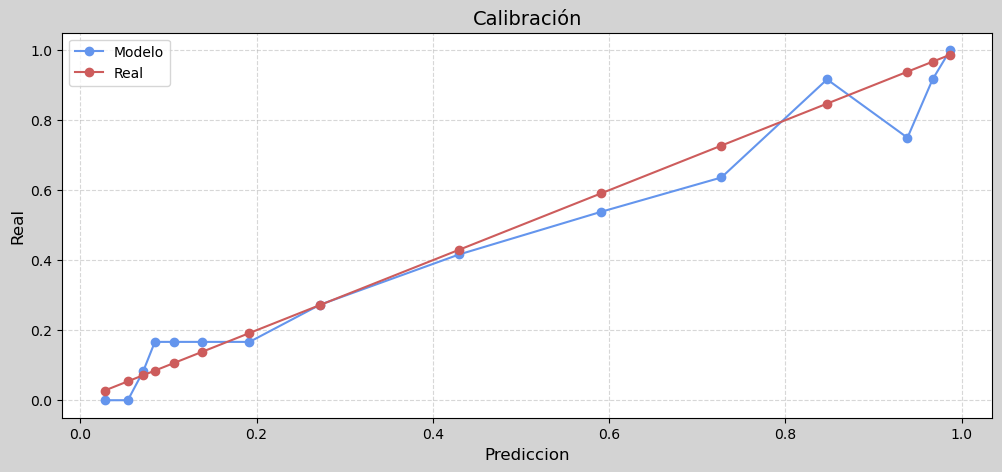

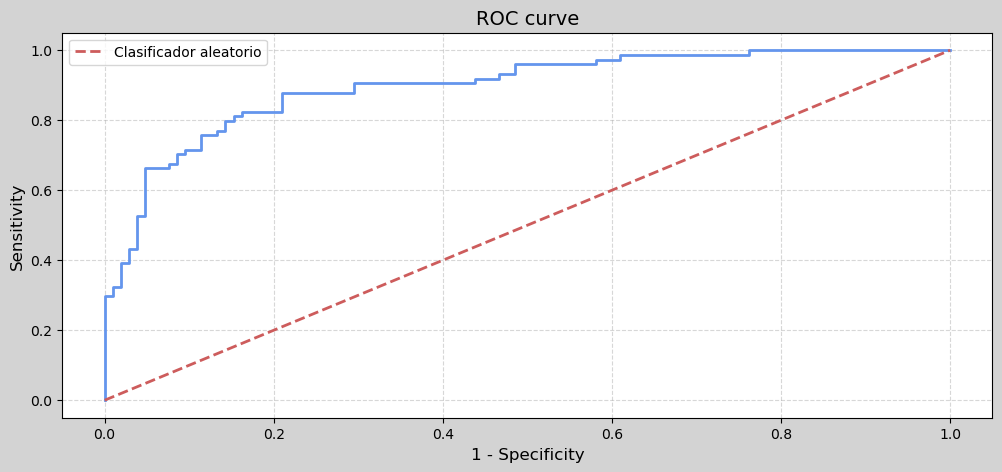

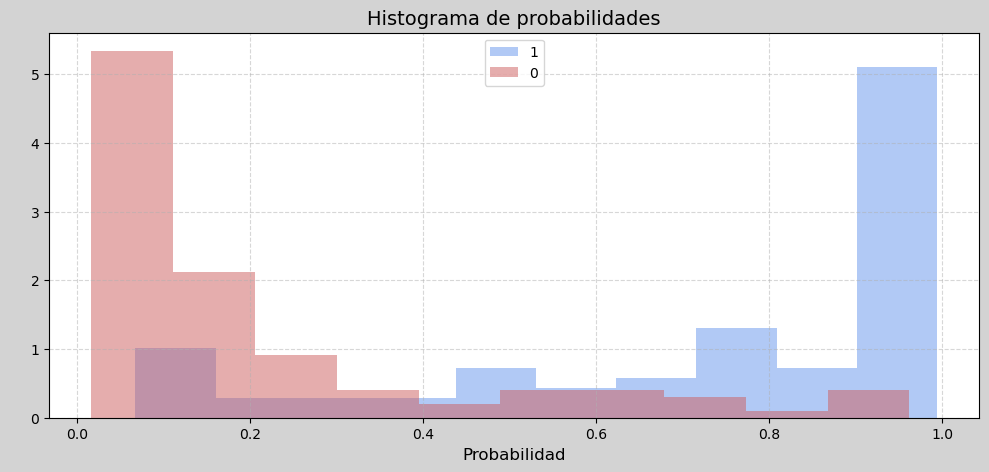

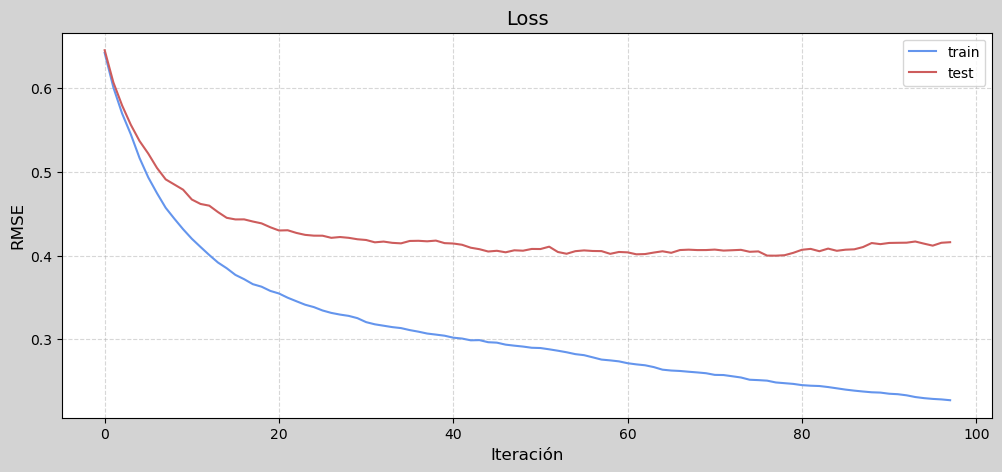

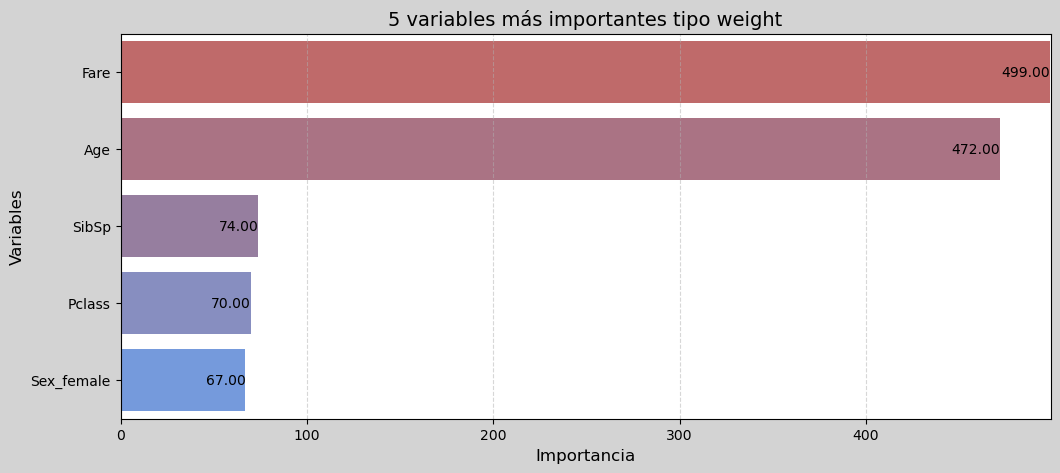

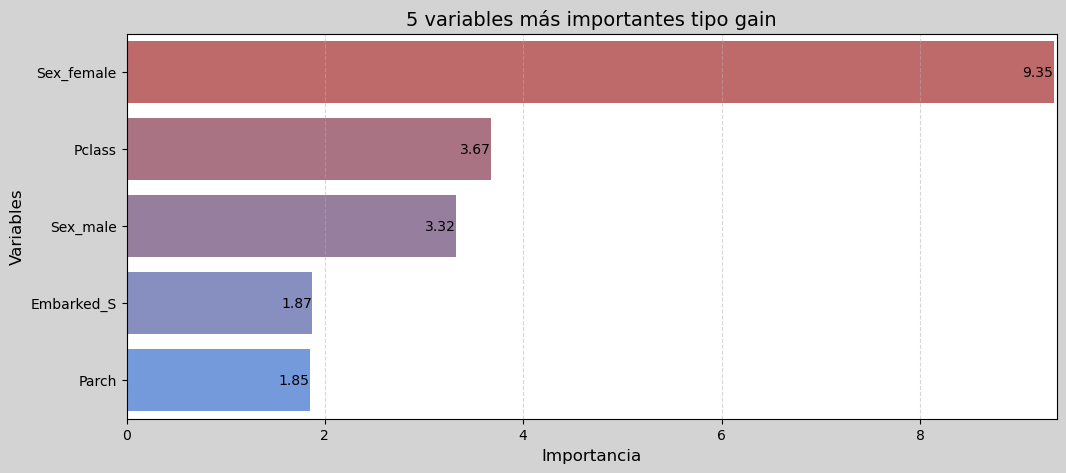

AUC: 0.8970
Gini: 0.7941


In [6]:
model = xgboost(X_train, X_test, y_train, y_test)

El modelo obtuvo un AUC de 0.7899 y un coeficiente de Gini de 0.5799. El valor de Gini, que mide la desigualdad en la distribución de las predicciones, refleja la capacidad del modelo para separar correctamente los casos positivos y negativos. Un Gini de 0.5799 indica que el modelo tiene un 57.99% de poder predictivo por encima del azar, lo que representa un desempeño sólido en términos de discriminación entre personas sobrevivientes y personas no sobrevivientes en el titanic.

# Shap values

## Conjunto de prueba

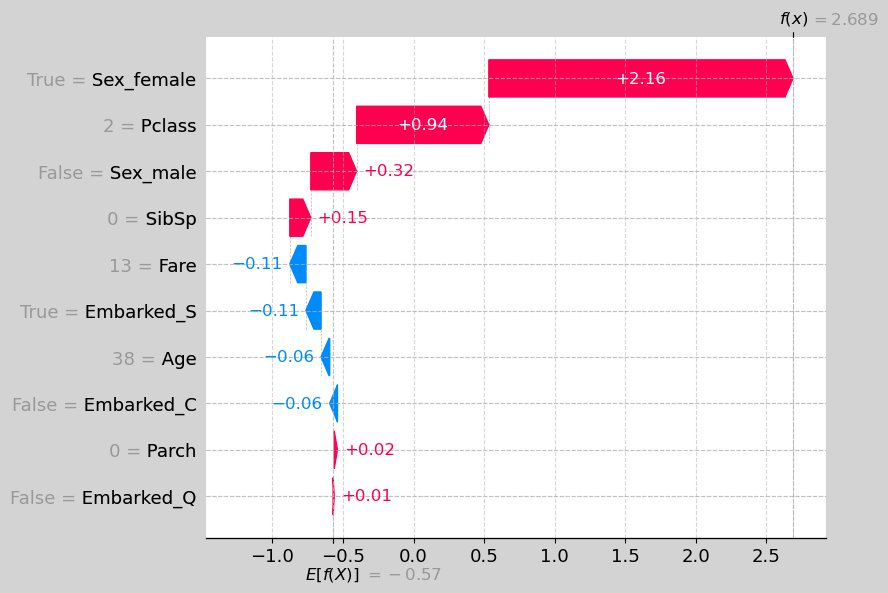

In [7]:
X_shap, shap_values = shap_prueba(X_test, model, 0, 10)

Esta gráfica nos muestra que para la persona 0 del dataset hay 2 características muy importantes al momento de realizar su predicción, las cuales son que sea mujer y que haya estado en la Pclass 2. Estas 2 características influyen en gran manera a que la predicción del modelo sea 1 (sobrevivió). Por otro lado las características que más restan a esta predicción son Fare 13 y Embarked_S, sin embargo estos valores son muy pequeños.

## Generales

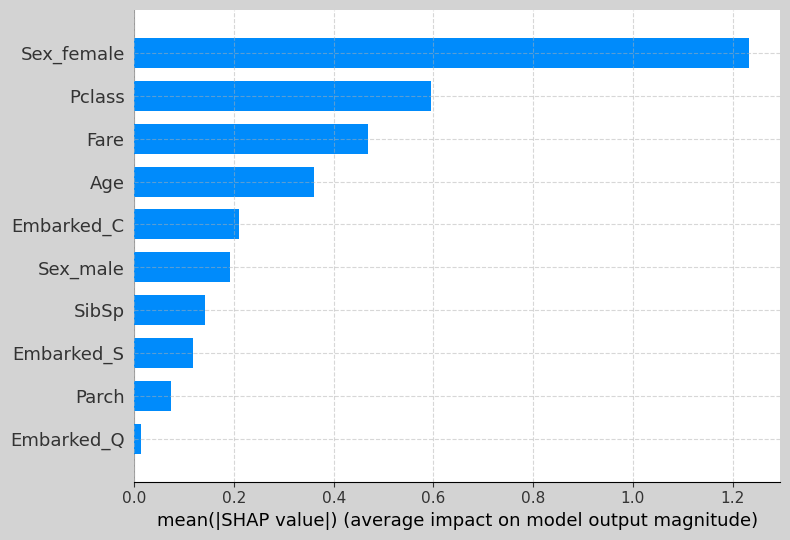

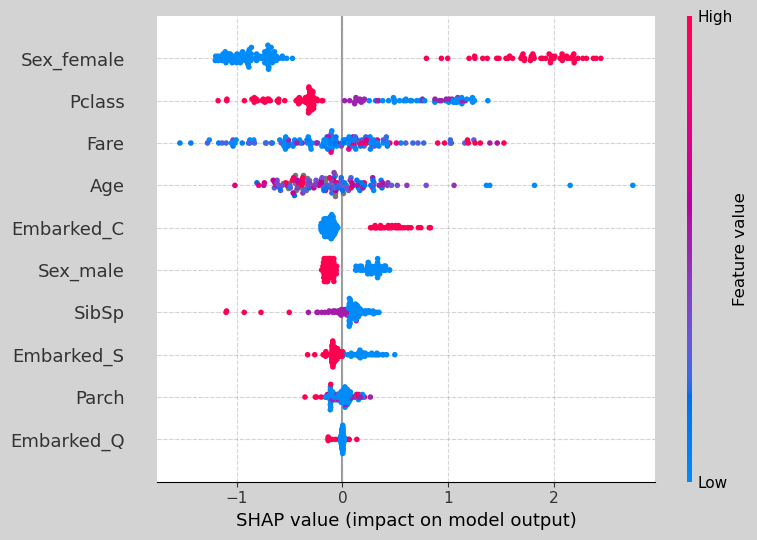

In [8]:
shap_plot(X_shap, shap_values, 10)

El gráfico de barras muestra el impacto promedio de las variables a todas las predicciones en general. Se puede ver que el feature que más impacto casusa es ser mujer, con un valor superior a 1. En segundo lugar se encuentra Pclass, con valor de 0.6 aproximadamente. El resto de features tiene un valor similar excepto por Embarqued_Q, el cual es notablemente el menor de todos con un valor muy cercano al 0.

Por otra parte el dotplot ayuda a ver la distribución por variable como una especie de mapa de calor. De igualmenterta es remarcable la distinciónn de sexo. Ya que es una variable dummy se nota muy claramente que si se es mujer el valor será alto y con un shap value positivo, mientras que si es hombre será bajo y negativo. Pasa algo similar con el embarque C, sin embargo con una magnitud muhco menor en los shap values. El resto de variables muestra una distribución mezclada y no tan significativa. Se puede concluir de manera muy segura que el sexo de la persona es el factor más determinante en la prediccion del modelo.

# KMeans

## Método del codo

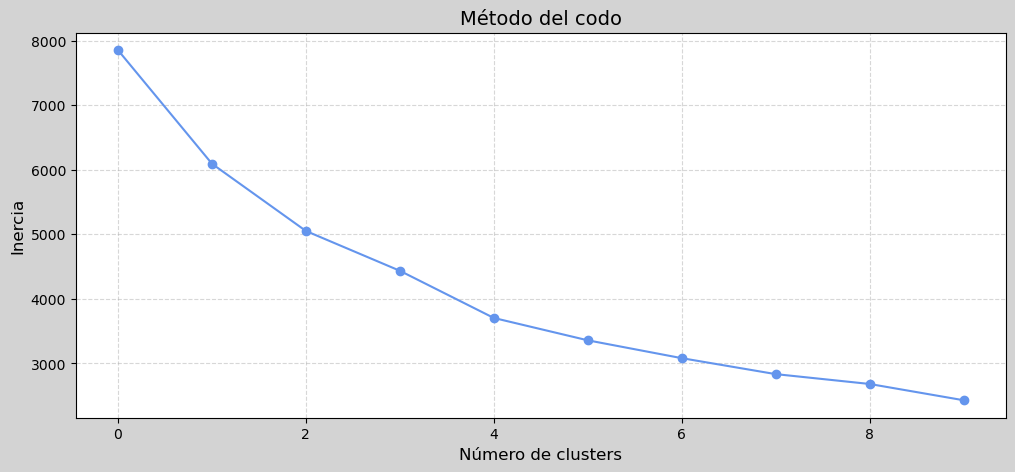

In [9]:
codo(data)

Usando el método del codo se puede determinar que la mejor opción para elegir en cuanto al número de clusters es de 3, pues es una especie de punto de quiebre en la ganancia de pérdida de error, aunque es cierto que mientras más clusters menos es el error, tras 3 clusters esta disminución no es tan significativa, por lo que se elige 3 como óptimo

## Clusterización

In [10]:
data = clusters(data, 3)
data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,cluster
0,0,3,22.0,1,0,7.2500,False,True,False,False,True,1
1,1,1,38.0,1,0,71.2833,True,False,True,False,False,0
2,1,3,26.0,0,0,7.9250,True,False,False,False,True,2
3,1,1,35.0,1,0,53.1000,True,False,False,False,True,2
4,0,3,35.0,0,0,8.0500,False,True,False,False,True,1


## Análisis clusters

In [11]:
data.groupby('cluster').mean()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
cluster,,,,,,,,,,,
0,0.607692,1.746154,30.814769,0.423077,0.415385,68.296767,0.469231,0.530769,1.0,0.000000,0.000000
1,0.179688,2.424479,30.318359,0.463542,0.260417,21.745809,0.000000,1.000000,0.0,0.041667,0.958333
2,0.710000,2.195000,27.785000,0.665000,0.770000,37.714563,1.000000,0.000000,0.0,0.060000,0.930000


Analizando la media por cluster por variable del dataset se puede observar que en promedio el 71% de las personas del cluster 2 han sobrevivido, mientras que del cluster 1 únicamente el 17.97%, esto se puede explicar con que el 100% de las personas del cluster 2 son mujeres, mientras que el 100% de las personas del cluster 1 son hombres. La edad promedio de los 3 cluster ronda al rededor de los 30 años. En su mayoría las perosnas del cluster 0 tuvieron una embarcación tipo C, mientras que las personas de los clusters 1 y 2 embarcaron S.

In [12]:
data.groupby('cluster').sum()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
cluster,,,,,,,,,,,
0,79,227,4005.92,55,54,8878.5797,61,69,130,0,0
1,69,931,11642.25,178,100,8350.3907,0,384,0,16,368
2,142,439,5557.00,133,154,7542.9126,200,0,0,12,186


Apoyando al análisis anterior se puede ver que el cluster en el que sobrevivieron el mayor número de personas es el 2, superando casi al doble al resto de clusters. Nuevamente esto refuerza lo previamente analizado, en donde se había dicho que ser hombre, disminuye considerablemente las probabilidades de haber sobrevivido al titanic. De los 384 hombres del cluster 1 únicamente sobrevivieron 69, mientras que de las 200 mujeres del cluster 2 sovrevivieron 142.